In [45]:
#load modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import io
import os
# import scikit-allel
import allel

In [26]:
#load the vcf file as a df with allel
df = allel.vcf_to_dataframe(r'C:\Users\mjgregoire\Documents\Pumpkin\filtVCF.recode.vcf', fields='*', alt_number=2)

In [29]:
df.head(5)
df.tail(5)

,CHROM,POS,ID,REF,ALT_1,ALT_2,QUAL,DB,FS,QD,...,FILTER_read_position,FILTER_RMxNRepeatRegion,FILTER_strand_artifact,FILTER_str_contraction,FILTER_too_few_supporting_reads,FILTER_weak_evidence,numalt,altlen_1,altlen_2,is_snp
57170,10,115437341,.,T,<NON_REF>,NaN,NaN,False,NaN,NaN,...,False,False,False,False,False,False,1,8,0,False
57171,10,115437364,.,G,<NON_REF>,NaN,NaN,False,NaN,NaN,...,False,False,False,False,False,False,1,8,0,False
57172,10,115437374,.,C,<NON_REF>,NaN,NaN,False,NaN,NaN,...,False,False,False,False,False,False,1,8,0,False
57173,10,115437375,.,G,<NON_REF>,NaN,NaN,False,NaN,NaN,...,False,False,False,False,False,False,1,8,0,False
57174,10,115437386,.,C,<NON_REF>,NaN,NaN,False,NaN,NaN,...,False,False,False,False,False,False,1,8,0,False


In [61]:
#count the number of SNPs
df.is_snp.value_counts()
#this means Pumpkin has no snps on this chromosome!!! So maybe I was wrong in thinking the cat chromosome D1 is chromosome 10... that's okay! 
#if only I knew more about cat genetics! 

False    17948503
Name: is_snp, dtype: int64

In [ ]:
#we can still use this vcf of chromosome 10 to look at things like hetrozygosity and variants across position on the chromosome

In [47]:
#read in the vcf as a python dict
callset = allel.read_vcf(r'C:\Users\mjgregoire\Documents\Pumpkin\filtVCF.recode.vcf', fields='*')
#check what the attributes of the vcf dict are
sorted(callset.keys()) 
#‘samples’ array contains sample identifiers extracted from the header line in the VCF file
#arrays with keys beginning ‘variants/’ come from the fixed fields in the VCF file
#arrays with keys beginning ‘calldata/’ come from the sample fields in the VCF file

['calldata/AD',
 'calldata/AF',
 'calldata/DP',
 'calldata/F1R2',
 'calldata/F2R1',
 'calldata/GP',
 'calldata/GQ',
 'calldata/GT',
 'calldata/ICNT',
 'calldata/MB',
 'calldata/MIN_DP',
 'calldata/PL',
 'calldata/PRI',
 'calldata/PS',
 'calldata/SB',
 'calldata/SPL',
 'calldata/SQ',
 'samples',
 'variants/ALT',
 'variants/CHROM',
 'variants/DB',
 'variants/DP',
 'variants/END',
 'variants/FILTER_DRAGENHardQUAL',
 'variants/FILTER_LowDepth',
 'variants/FILTER_LowGQ',
 'variants/FILTER_PASS',
 'variants/FILTER_PloidyConflict',
 'variants/FILTER_RMxNRepeatRegion',
 'variants/FILTER_base_quality',
 'variants/FILTER_filtered_reads',
 'variants/FILTER_fragment_length',
 'variants/FILTER_long_indel',
 'variants/FILTER_low_depth',
 'variants/FILTER_low_frac_info_reads',
 'variants/FILTER_low_normal_depth',
 'variants/FILTER_mapping_quality',
 'variants/FILTER_multiallelic',
 'variants/FILTER_no_reliable_supporting_read',
 'variants/FILTER_non_homref_normal',
 'variants/FILTER_panel_of_normals'

In [37]:
#make a genotype array based on the vcf file
gt = allel.GenotypeArray(callset['calldata/GT'])
gt
#count the number of heterozygous calls per variant
gt.count_het(axis=1)
#count the number times each allele (0=reference, 1=first alternate, 2=second alternate, etc.) is observed for each variant
ac = gt.count_alleles()
ac

<AlleleCountsArray shape=(17948503, 8) dtype=int32>
2 0 0 0 0 0 0 0
2 0 0 0 0 0 0 0
2 0 0 0 0 0 0 0
...
0 0 0 0 0 0 0 0
2 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0

In [42]:
#check the number of filtered reads that support each of the reported alleles
callset = allel.read_vcf(r'C:\Users\mjgregoire\Documents\Pumpkin\filtVCF.recode.vcf', fields=['variants/DP', 'calldata/DP'])
sorted(callset.keys())

['calldata/DP', 'variants/DP']

In [43]:
callset['variants/DP']

array([-1, -1, -1, ..., -1, -1, -1])

In [44]:
callset['calldata/DP']

array([[2],
       [5],
       [8],
       ...,
       [1],
       [1],
       [0]], dtype=int16)

In [48]:
#get the positions
pos = allel.SortedIndex(callset['variants/POS'])
pos

0,1,2,3,4,...,17948498,17948499,17948500,17948501,17948502
1,31,55,58,65,...,115437341,115437364,115437374,115437375,115437386


In [49]:
#define a function to plot the density of the variants based on position
def plot_windowed_variant_density(pos, window_size, title=None):
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)

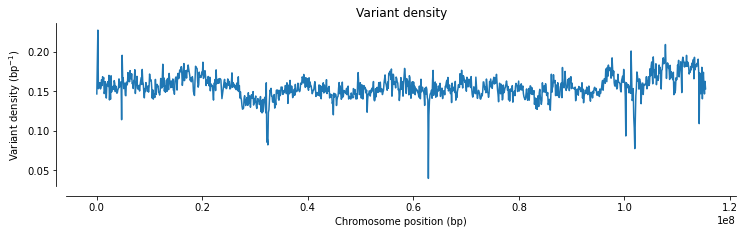

In [54]:
#look at the graph
plot_windowed_variant_density(pos, window_size=100000, title='Variant density')
#save the graph as a figure
plt.savefig(r'C:\Users\mjgregoire\Documents\Pumpkin\variantDensity.png')